<div style="background:#F5F7FA; height:100px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Want to do more?</span><span style="border: 1px solid #3d70b2;padding: 15px;float:right;margin-right:40px; color:#3d70b2; "><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
<span style="color:#5A6872;"> Try out this notebook with your free trial of IBM Watson Studio.</span>
</div>

# Build and use a data model in real time with the Python API

You can follow the steps and code in this Python notebook to create a sample data set, create a model for the sample data, use that model in a streaming application, visualize the streaming data, and finally submit the streaming application to the Streaming Analytics service running on IBM Cloud. 

Familiarity with Python and Jupyter Notebooks is recommended. 
This notebook runs on Python 3.5 with Spark 2.1.

## Table of contents
***
1.	[Setup](#setup)
1.  [Create a sample data set](#create_data)
1.  [Create a model for sample data](#create_model)
1.  [Use the model in a real-time streaming application](#use_model)
1.	[Define and submit the streaming application](#build)
1.	[View the streaming data](#visualize)
1.	[Summary and next steps](#summary)
***

<a id="setup"></a>
## 1. Setup
<br/>
<div class="alert alert-block alert-success">If you completed the setup steps once already for your Streaming Analytics service, make sure that it is running and then skip to <a href="#create_data">Create a sample data set</a>.</div>

Before you can use the example Python code in this notebook, complete these steps:
1.	[Install Python library](#install)
1.	[Start the Streaming Analytics service](#start)
1.	[Set up access to the service](#access)

<a id="install"></a>
### 1.1. Install Python library

Run the following cell to install the latest package from <a href="http://www.pybrain.org/docs/" target="_blank" rel="noopener noreferrer">PyBrain</a> into your Watson Studio environment. PyBrain is a machine learning library for Python and it's required to:

 - Create sample data that shows the average temperature of an engine for a given period of time, and calculates the engine's probability of failure.
 - Create a data model that reads the temperature of an engine and calculates the engine's probability of failure based on temperature readings.   
 - Use the data model in a streaming application.

In [ ]:
!pip install git+https://github.com/pybrain/pybrain.git

<a id="start"></a>
### 1.2 Start the Streaming Analytics service

Open the IBM Cloud web portal and <a href="https://console.ng.bluemix.net/" target="_blank" rel="noopener noreferrer">log in or sign up for a free IBM Cloud account</a>.

Ensure that your Streaming Analytics service is running in IBM Cloud.

**If you don’t have a service,** you can create one as follows:  
1. Click **Catalog** or **Create Service**, browse for the `Streaming Analytics` and then click it. <br>
1. Follow the instructions on the  Streaming Analytics catalog page, type the *Service name* to set up your service.
<img src='https://github.com/orzade/streamsx-notebooks/blob/master/servicename.png?raw=true' alt="Type your service name and click on Create" title="Streaming Analytics catalog - Type your service name"></img><br>
1. Click **Create** to open the Streaming Analytics service dashboard.<br> Your service starts automatically.

<a id="access"></a>
### 1.3 Set up access to the service

Before you create an app with this notebook, you must first provide the information that your streaming app needs to access the service. You can find this information on the Streaming Analytics service dashboard. It includes the service name, the service credentials, and the connection URL for the service. 

Start by running the following cell, and then entering the name of your service when prompted.

**Tip:** If you are not prompted to enter the service name, click **Kernel -> Restart** on the menu bar and rerun the cell.

In [ ]:
service_name=input('Streaming Analytics name:')

In the next step you have to enter your service credentials. To copy your service credentials, open the Streaming Analytics service dashboard click **Service Credentials**, then **View Credentials**, and finally click the Copy icon.

<img src='https://github.com/orzade/streamsx-notebooks/blob/master/copyservicecredentials.png?raw=true' alt="Copy your service credentials" title="Streaming Analytics catalog - Copy your service credentials"></img>

Then run the following cell and paste your service credentials when prompted.

In [ ]:
import getpass
credentials=getpass.getpass('Streaming Analytics credentials:')

<a id="create_data"></a>
## 2. Create a sample data set

Run the following cell to create a sample data set. The x-axis shows the average temperature of an engine over the past two hours, and the y-axis shows the probability that the engine will fail in the next 30 minutes.

<IPython.core.display.Javascript object>


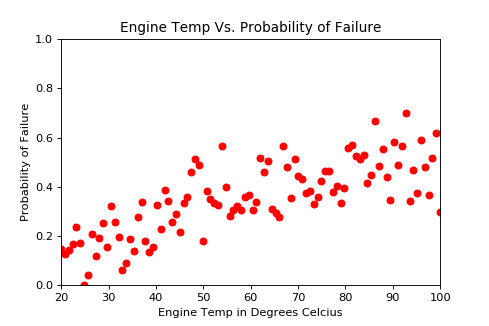

(<matplotlib.figure.Figure at 0x7fa3cb63eef0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa3a37c3dd8>)

In [5]:
%matplotlib inline
%matplotlib notebook

import numpy as np, math
import matplotlib.pyplot as plt
from pybrain.datasets import SupervisedDataSet
from pybrain.structure import SigmoidLayer, LinearLayer
from pybrain.tools.shortcuts import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer

# Create sample dataset
xvalues = np.linspace(20,100, 100)
yvalues = np.array([((np.cos((x-50)/100)*100 + np.sin(x/100)*100 + np.random.normal(0, 13, 1)[0])/150.0) for x in xvalues])
yvalues = [y - np.amin(yvalues) for y in yvalues]

# Plot dataset
def create_plot(xvalues, yvalues, title=None, xlabel=None, ylabel=None, xlim=None, ylim=None):
    fig, ax = plt.subplots()
    plt.title("Engine Temp Vs. Probability of Failure")
    plt.ylabel("Probability of Failure")
    plt.xlabel("Engine Temp in Degrees Celcius")
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.plot(xvalues,
            yvalues, "ro", linewidth = 2, color = 'red', label = 'target')
    return fig,ax

create_plot(xvalues, yvalues, title="Engine Temp Vs. Probability of Failure", xlabel = "Probability of Failure", 
            ylabel = "Engine Temp in Degrees Celcius", xlim = (20,100), ylim = (0,1))


<a id="create_model"></a>
## 3. Create a model for sample data

You can now create a model which takes an engine's temperature reading, and provides an approximate probability of failure. To create this model, use the PyBrain library which trains a feedforward neural network (FFN) to predict failure probability of the engine. 

Run the following cell to see the model improving itself interactively. The blue line shows the model's fit to the data.

<IPython.core.display.Javascript object>


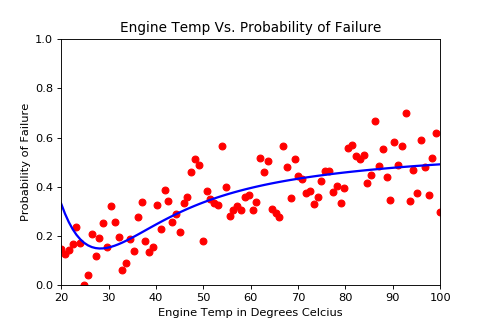

In [6]:
# The neural net to be trained
net = buildNetwork(1,100,100,100,1, bias = True, hiddenclass = SigmoidLayer, outclass = LinearLayer)

# Construct a data set of the training data
ds = SupervisedDataSet(1, 1)
for x, y in zip(xvalues, yvalues):
    ds.addSample((x,), (y,))

# The training harness. Used to train the model.
trainer = BackpropTrainer(net, ds, learningrate = 0.0001, momentum=0, verbose = False, batchlearning=False)

# Train the model. Display the model in the plot on each iteration.
fig, ax = create_plot(xvalues, yvalues, title="Engine Temp Vs. Probability of Failure", xlabel = "Probability of Failure", 
            ylabel = "Engine Temp in Degrees Celcius", xlim = (20,100), ylim = (0,1))

ax.plot(xvalues, [net.activate([x]) for x in xvalues], linewidth = 2, color = 'blue', label = 'NN output')

for i in range(50):
    trainer.train()
    new_yvalues = [net.activate([x]) for x in xvalues]
    ax.lines[1].set_ydata(new_yvalues)
    fig.canvas.draw()   

<a id="use_model"></a>
## 4. Use the model in a real-time streaming application

In the above cell, you trained a model to predict failure given a temperature reading. This model is represented as a Python object called `net`. To insert the model into a real-time streaming application with the streamsx.topology Python API, you must use classes that create and manipulate streaming data.

The two classes in the following cell represent such creation and manipulation of data. The `periodicSource` class submits a random number between 20 and 100 every 0.1 seconds. You can use this class to simulate sample temperature readings.

The `neural_net_model` class simply takes a data item, feeds it as input to the neural net, and returns the output onto a stream.

In [7]:
# The source of our data. Every 0.1 seconds, a number between 20-100 will be inserted into the stream
# INPUT: None
# OUTPUT: A float with range [20,100]
class periodicSource(object):
    def __call__(self):
        while True:
            time.sleep(0.1)
            yield random.uniform(20,100)

# A class which runs the neural net on data it is passed.
# INPUT: the input to the neural net, in this case a floating point number
# OUTPUT: an array containing the output of the neural net, as well as the input to the neural net.
class neural_net_model(object):
    def __init__(self, net):
        self.net = net
    def __call__(self, num):
        return [num, self.net.activate([num])[0]]

<a id="build"></a>
## 5. Define and submit the streaming application

Run the following cell to create instances of the classes that create and process data. Each tuple produced by the `periodicSource` class represents a temperature reading to be passed into, and processed by, the `neural_net_model` class. The `neural_net_model` class produces the probability of failure calculation. Finally, you run the application with the `STREAMING_ANALYTICS_SERVICE` context to submit it to the Streaming Analytics service on IBM Cloud.

In [8]:
from streamsx.topology import topology, context
import random
import json 
import time

# Define operator
periodic_src = periodicSource()
nnm = neural_net_model(net)

# Build Graph
top = topology.Topology("myTop")

stream_ = top.source(periodic_src)
stream_.publish("asdf")

view = stream_.transform(nnm).view()

# Submit

vs={'streaming-analytics': [{'name': service_name, 'credentials': json.loads (credentials)}]}
cfg = {context.ConfigParams.VCAP_SERVICES : vs, context.ConfigParams.SERVICE_NAME : service_name}
job = context.submit(context.ContextTypes.STREAMING_ANALYTICS_SERVICE, top, config=cfg)

Mar 13, 2018 7:53:58 AM com.ibm.streamsx.topology.internal.context.remote.BuildServiceRemoteRESTWrapper remoteBuildAndSubmit
INFO: Streaming Analytics service (Streaming Analytics): Checking status
Mar 13, 2018 7:54:02 AM com.ibm.streamsx.topology.internal.streaminganalytics.RestUtils checkInstanceStatus
INFO: Streaming Analytics service (Streaming Analytics): instance status response:{"state":"STARTED","plan":"lite","enabled":true,"status":"running"}
Mar 13, 2018 7:54:02 AM com.ibm.streamsx.topology.internal.context.remote.BuildServiceRemoteRESTWrapper remoteBuildAndSubmit
INFO: Streaming Analytics service (Streaming Analytics): submitting build myTop_C67248812611EBEA
Mar 13, 2018 7:55:04 AM com.ibm.streamsx.topology.internal.context.remote.BuildServiceRemoteRESTWrapper remoteBuildAndSubmit
INFO: Streaming Analytics service (Streaming Analytics): submitting job request.
Mar 13, 2018 7:55:29 AM com.ibm.streamsx.topology.internal.context.remote.BuildServiceRemoteRESTWrapper doSubmitJobF

<a id="visualize"></a>
## 6. View the streaming data

You can now visualize the model in Jupyter by calling the `start_data_fetch` method of the view. By calling this method, you will place the data on a queue to be retrieved and graphed.

<IPython.core.display.Javascript object>


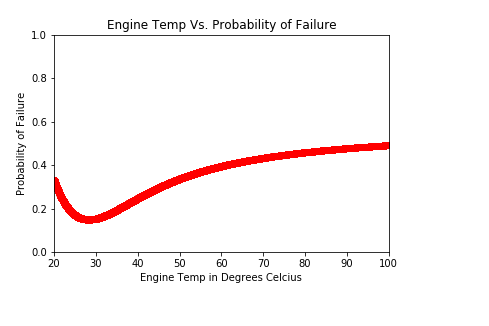

In [ ]:
fig, ax = create_plot([], [], title="Engine Temp Vs. Probability of Failure", xlabel = "Probability of Failure", 
            ylabel = "Engine Temp in Degrees Celcius", xlim = (20,100), ylim = (0,1))
xdata = []
ydata = []
    
try:
    queue = view.start_data_fetch()

    for line in iter(queue.get, None):
        xdata.append(line[0])
        ydata.append(float(line[1]))
        ax.lines[0].set_xdata(xdata)
        ax.lines[0].set_ydata(ydata)
        fig.canvas.draw()
except:
    raise
finally:
    view.stop_data_fetch()

<a id="summary"></a>
## 5. Summary and next steps

You learned how to create a sample data set, create a model for the sample data, and use that data model in a streaming application. You also learned how to visualize the streaming data, and then submit the streaming application to the Streaming Analytics service on IBM Cloud. 

Check out other notebooks in this series: 
 - <a href="https://apsportal.ibm.com/exchange/public/entry/view/9fc33ce7301f10e21a9f92039cad29a6" target="_blank" rel="noopener noreferrer">Healthcare Python Streaming Application Demo</a>
 - <a href="https://apsportal.ibm.com/exchange/public/entry/view/9fc33ce7301f10e21a9f92039ca9c6e8" target="_blank" rel="noopener noreferrer">Build a Python app on the Streaming Analytics service</a>

Dig deeper:
 - <a href="http://ibmstreams.github.io/streamsx.documentation/docs/latest/python/python-appapi-devguide/#developing-ibm-streams-applications-with-python" target="_blank" rel="noopener noreferrer">Developing IBM Streams applications with Python</a>
 - <a href="https://www.ibm.com/support/knowledgecenter/SSCRJU/SSCRJU_welcome.html" target="_blank" rel="noopener noreferrer">IBM Streams documentation</a> 
 
### Author
 Will Marshall is a software developer who specializes in streaming technology and cloud solutions. 

Copyright © 2017, 2018 IBM. This notebook and its source code are released under the terms of the MIT License.